### SEGAN without the GAN

Original SEGAN paper: https://arxiv.org/pdf/1703.09452.pdf

In [2]:
import os
import torch
import re
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import SpeechDataset
import time
from model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio

In [3]:
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())

True
True


In [4]:
num_epochs = 100
batch_size = 256
learning_rate = 1e-4

In [5]:
epochs = filter(lambda x: re.search("^seae_epoch_\d+\.pth$", x), os.listdir('models'))
epochs = map(lambda x: int(re.search("^seae_epoch_(\d+)\.pth$", x)[1]), epochs)
last_epoch = max(epochs)

In [6]:
#MODEL_PATH = f'models/seae_epoch_{last_epoch}.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [7]:
dataset = SpeechDataset('data/clean/360/', 'data/noise/', window_size=16384, overlap=50, snr=10)

In [8]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
last_epoch = 0

In [10]:
def SDRLoss(output, target):
    output = output.view(-1, 16384)
    target = target.view(-1, 16384)
    
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    
    return loss

In [11]:
def weightedSDR(output, target, x):
    noise = x - target
    expected_noise = x - output 
    
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

In [12]:
model = Autoencoder(bs=batch_size).cuda()
#model.load_state_dict(torch.load(MODEL_PATH))
criterion = weightedSDR
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()
for i in range(20):
    data = next(iter(dataloader))
for epoch in trange(num_epochs):
    #print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    #pbar = tqdm()
    #pbar.reset(total=(len(dataset) // batch_size))
    
    # for i, data in enumerate(dataloader):
    inp = data[0].clone().detach().cuda()
    expected = data[1].clone().detach().cuda()
    output = model(inp)
    loss = criterion(output, expected, inp)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #pbar.update()
    
    #pbar.refresh()
    
    #torch.save(model.state_dict(), f'models/noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if epoch % 5 == 0:
        print(f'epoch [{epoch}/{num_epochs}]')

        print(round(loss.item(), 5))

epoch [0/100]
-0.07171
epoch [5/100]
-0.65005
epoch [10/100]
-0.71443
epoch [15/100]
-0.7381
epoch [20/100]
-0.76894
epoch [25/100]
-0.78818
epoch [30/100]
-0.80093
epoch [35/100]
-0.81578
epoch [40/100]
-0.82124
epoch [45/100]
-0.8324
epoch [50/100]
-0.83864
epoch [55/100]
-0.83882
epoch [60/100]
-0.85215
epoch [65/100]
-0.84974
epoch [70/100]
-0.85952
epoch [75/100]
-0.8607
epoch [80/100]
-0.86535
epoch [85/100]
-0.86917
epoch [90/100]
-0.87088
epoch [95/100]
-0.87445



In [ ]:
# model = Autoencoder(bs=batch_size).cuda()
# model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
#model

2.0451


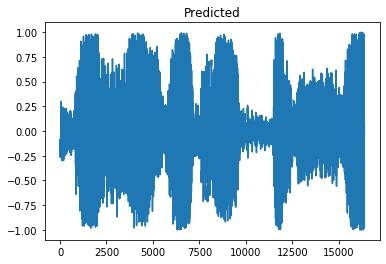

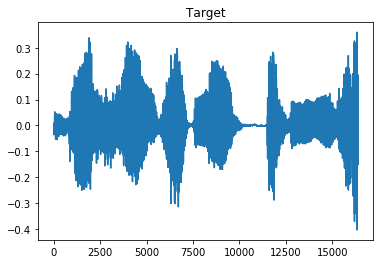

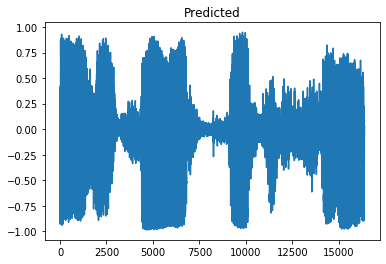

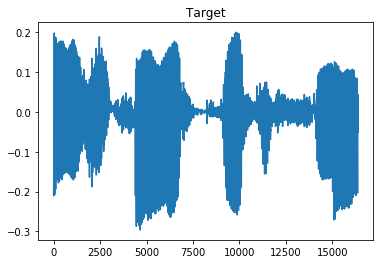

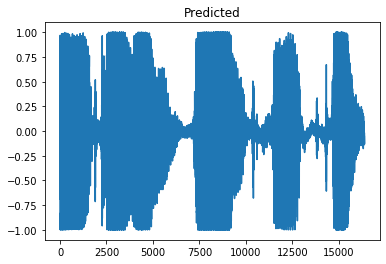

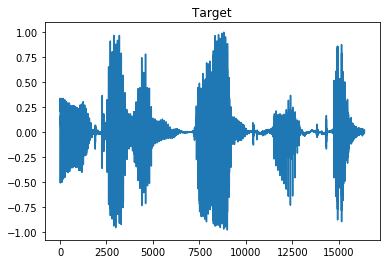

In [14]:
pesqs = []

#data = next(iter(dataloader))
model.eval()
with torch.no_grad():
    sample = data[1].cuda()
    
    for i, _s in enumerate(sample[:3]):
        output = model(data[0].cuda())
        ref = output[i, :, :].cpu().detach().numpy().T[:, 0]
        target = sample[i, :, :].cpu().detach().numpy().T[:, 0]
        plt.figure()
        plt.title('Predicted')
        plt.plot(ref)
        plt.figure()
        plt.title('Target')
        plt.plot(target)

        pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))
Audio(target, rate=16000)

In [ ]:
specgram = torchaudio.transforms.Spectrogram(1024, 300)(ref)
pdb.set_trace()
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy())
